# Binding energy calculation

## Justification

For two interacting RNAs, their binding energy and thus likelihood of interacting may be found through a variety of RNA simulators. In practice, this binding energy $\Delta G$ may translate into actual binding and subsequent repression in a genetic circuit through the forward and reverse equilibrium rates of the reaction. Both of these will vary based on the RNA, so we have chosen to parameterise the RNA binding from existing data using the research paper ["Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs" (2013)](https://www.nature.com/articles/nbt.2461#Fig1). A sigmoid function was fit to data of RNA binding energy vs. fluorescence, which was used as a proxy for measuring repression efficiency. 

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

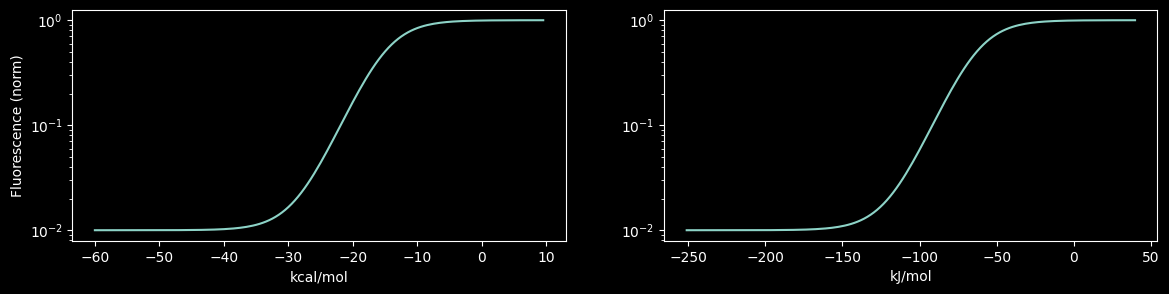

In [145]:
def cal_to_j(E_cal):
    return E_cal * 4.184


def j_to_cal(E_j):
    return E_j / 4.184


def binding_energy_sigmoid(E):
    """ The binding energy is in units of kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/3 + 5))) + 0.01
    return F


def binding_energy_sigmoid_J(E):
    """ The binding energy is in units of kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/12.552 + 5))) + 0.01
    return F


E = np.arange(-60, 10, 0.5)

plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.plot(
    E,
    binding_energy_sigmoid(E)
)
plt.xlabel('kcal/mol')
plt.ylabel('Fluorescence (norm)')
plt.yscale('log')

ax = plt.subplot(1, 2, 2)
plt.plot(
    cal_to_j(E),
    binding_energy_sigmoid_J(cal_to_j(E))
)
plt.xlabel('kJ/mol')
plt.yscale('log')


Now we need to relate the fluorescence to the equilibrium rates. We have previously derived an approximation for this in the following manner, where $F = $ fluorescence, $D = $ free DNA, $S = $ sRNA, $SD = $ bound DNA, $k_a = $ association rate, $k_d = $ dissociation rate, and $K = $ equilibrium constant:

$$F = \frac{[D]}{([D] + [SD])} $$
$$\frac{1}{F} - 1 = \frac{[SD]}{[D]}$$

We already know the equilibrium constant from $\Delta G$:

$$K = e^{- \Delta G / RT} = \frac{k_a}{k_d} = \frac{[Product]}{[Reactants]} = \frac{[SD]}{[S][D]}$$

We also know that for different fluorescences, different forward and reverse rates must be in play.

$$F = 1 \to k_d >> k_a $$
$$F = 0.001 \to k_d << k_a $$
$$F = 0.5 \to [D] = [SD] \to \frac{k_a}{k_d} = \frac{[SD]}{[S][D]} \approx \frac{1}{[S]} $$
$$F = 0.25 \to [D] = 3[SD] \to \frac{k_a}{k_d} = \frac{3[SD]}{[S][D]} \approx \frac{3}{[S]} $$

$$\frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1}{F} - 1 \big) $$

In the code above, we have fit a sigmoid curve to the data in the research paper. This fit curve gives

$$F(\Delta G) \approx \frac{1}{1 + e^{-(\Delta G / 12.552 + 5)}} + 0.01 $$

If we expand this out and make fluorescence dependent on the minimum free energy of binding \Delta G:

$$K = \frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1}{\frac{1}{1 + e^{-(\Delta G / 12.552 + 5)}} + 0.01} - 1 \big) $$

Since we have also estimated a constant value for association constant $k_a$, this would be used to find the dissociation constant. The only question is what to do with the S term in the final equation. Since we know that at half the normalised fluorescence $F = 0.5$, the equilibrium constant should be equal to 1 ($K = 1$), as the ratio of bound to unbound species should be 1. From this, we can find the concentration $[S]$ that fulfills the equation.


Text(0.5, 1.0, 'k_d, [S] = 1mol')

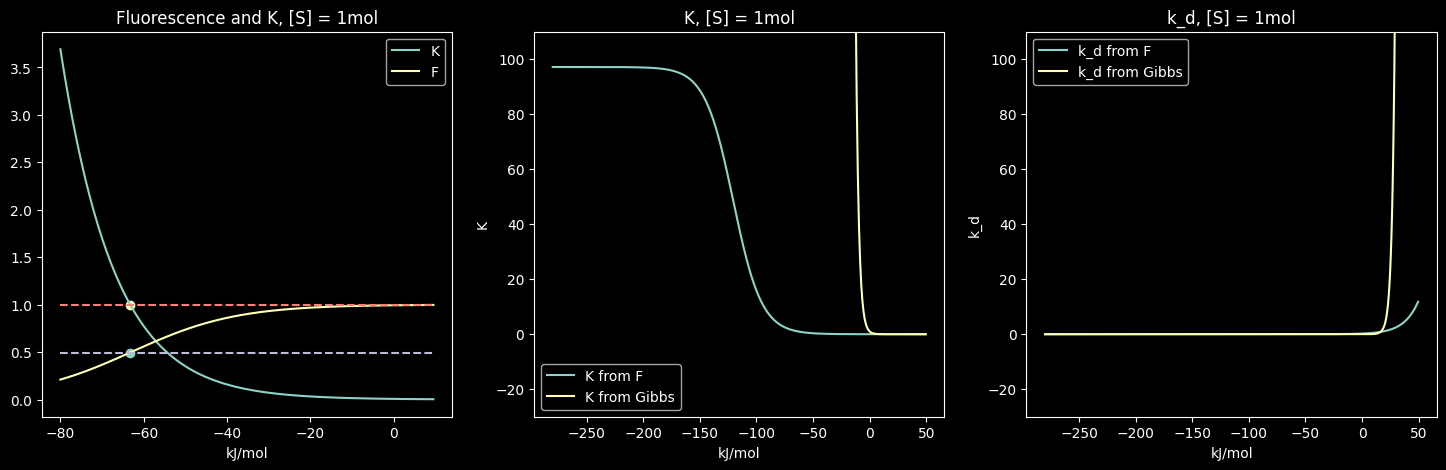

In [144]:
def F(E):
    """ kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/12.552 + 5))) + 0.01
    return F
    # return 1/(1+np.exp(-(E/3 + 5))) + 0.01


def gibbs_K(E):
    """ In kJ/mol. dG = - RT ln(K) """
    RT = 8.314 * 310
    E = E * 1000
    K = np.exp(-E/(RT))
    return K


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kj/mol """
    return 1/initial * (1/F(E) - 1)


E = np.arange(-80, 10, 0.5)
E_F_half = -63.25
initial = 1/1 * (1/F(E_F_half) - 1)
k_a = 0.0015


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(
    E,
    equilibrium_constant_fluorescence(E, initial),
    label='K'
)
plt.xlabel('kJ/mol')
# plt.yscale('log')
plt.plot(
    E,
    F(E),
    label='F'
)
plt.scatter(E_F_half, F(E_F_half))
plt.scatter(E_F_half, equilibrium_constant_fluorescence(E_F_half, initial))
plt.plot(E, np.ones_like(E) * F(E_F_half), '--')
plt.plot(E, np.ones_like(E) * equilibrium_constant_fluorescence(E_F_half, initial), '--')
plt.legend()
plt.title('Fluorescence and K, [S] = 1mol')

ax = plt.subplot(1, 3, 2)
E2 = np.arange(-280, 50, 0.5)
plt.plot(E2, equilibrium_constant_fluorescence(E2, initial), label='K from F')
plt.plot(E2, gibbs_K(E2), label='K from Gibbs')
plt.legend()
plt.xlabel('kJ/mol')
plt.ylabel('K')
plt.ylim(-30, 110)
plt.title('K, [S] = 1mol')

ax = plt.subplot(1, 3, 3)
plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, initial), label='k_d from F')
plt.plot(E2, k_a/gibbs_K(E2), label='k_d from Gibbs')
plt.legend()
plt.xlabel('kJ/mol')
plt.ylabel('k_d')
plt.ylim(-30, 110)
plt.title('k_d, [S] = 1mol')




In this case, $[S]$ turned out to be roughly equal to 1 mol for the $\Delta G$ where F = 0.5 the same as that for making $K = 1$, which turned out to be roughly around $\Delta G = - 63.25$ kJ/mol.
For comparison, the original equation for K and $\Delta G$ is plotted as well and shows a much faster increase past 1, around -5 kJ/mol.

Text(0.5, 1.0, 'K at different [S]')

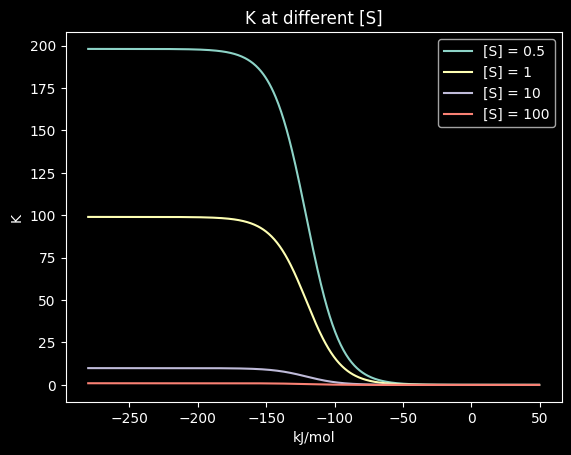

In [147]:
S = [0.5, 1, 10, 100]

plt.figure()
for s in S:
    plt.plot(E2, equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')

plt.legend()
plt.xlabel('kJ/mol')
plt.ylabel('K')
plt.title('K at different [S]')
